In [48]:
import json

creds = json.load(open("kaggle.json"))
username = creds["username"]
key = creds["key"]

!curl -L -o sentiment-analysis-dataset.zip \
  -u {username}:{key} \
  https://www.kaggle.com/api/v1/datasets/download/abhi8923shriv/sentiment-analysis-dataset

!mkdir -p ./data
!unzip sentiment-analysis-dataset.zip -d ./data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 54.4M  100 54.4M    0     0  48.8M      0  0:00:01  0:00:01 --:--:--  127M
Archive:  sentiment-analysis-dataset.zip
replace ./data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Preprocess the Data

In [49]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

In [109]:
df = pd.read_csv('/content/data/train.csv', encoding='latin1')
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [110]:
df = df.drop(columns=['textID', 'selected_text'])

Cleaning the Text

In [111]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"[^a-z\s]", '', text)         # remove punctuation/numbers
    text = re.sub(r"\s+", ' ', text).strip()     # remove extra spaces
    return text

df['text'] = df['text'].apply(clean_text)

In [54]:
df['text']

,text
0,id have responded if i were going
1,sooo sad i will miss you here in san diego
2,my boss is bullying me
3,what interview leave me alone
4,sons of why couldnt they put them on the relea...
...,...
27476,wish we could come see u on denver husband los...
27477,ive wondered about rake to the client has made...
27478,yay good for both of you enjoy the break you p...
27479,but it was worth it


In [112]:
le_sentiment = LabelEncoder()
y = le_sentiment.fit_transform(df['sentiment'])
df = df.drop(columns=['sentiment'])
print(le_sentiment.classes_)
print(y)

['negative' 'neutral' 'positive']
[1 0 0 ... 2 2 1]


In [113]:
def age_to_midpoint(age_range):
    if isinstance(age_range, str) and '-' in age_range:
        low, high = age_range.split('-')
        return (int(low) + int(high)) / 2
    return np.nan

df['Age of User'] = df['Age of User'].apply(age_to_midpoint)
df['Age of User']

,Age of User
0,10.0
1,25.5
2,38.0
3,53.0
4,65.0
...,...
27476,38.0
27477,53.0
27478,65.0
27479,85.0


In [114]:
numeric_features = ['Age of User', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [115]:
categorical_features = ['Time of Tweet', 'Country']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [116]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = vectorizer.fit_transform(df['text'])

In [117]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_other = preprocessor.fit_transform(df)

In [118]:
X = hstack([X_text, X_other])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
X_train, y_train

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 411714 stored elements and shape (21984, 5202)>,
 array([1, 1, 1, ..., 1, 0, 0]))

# Supervised ML

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"---{name}---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

---LogisticRegression---
Accuracy: 0.6812806985628524
              precision    recall  f1-score   support

           0       0.71      0.61      0.65      1562
           1       0.62      0.72      0.67      2230
           2       0.76      0.69      0.73      1705

    accuracy                           0.68      5497
   macro avg       0.70      0.67      0.68      5497
weighted avg       0.69      0.68      0.68      5497

---SVM---
Accuracy: 0.6057849736219756
              precision    recall  f1-score   support

           0       0.74      0.34      0.46      1562
           1       0.52      0.87      0.65      2230
           2       0.83      0.50      0.63      1705

    accuracy                           0.61      5497
   macro avg       0.70      0.57      0.58      5497
weighted avg       0.68      0.61      0.59      5497

---RandomForest---
Accuracy: 0.6783700200109151
              precision    recall  f1-score   support

           0       0.72      0.55      0.6

---LogisticRegression3000---
Accuracy: 0.6809168637438603
              precision    recall  f1-score   support

           0       0.71      0.61      0.65      1562
           1       0.62      0.72      0.67      2230
           2       0.76      0.70      0.73      1705

    accuracy                           0.68      5497
   macro avg       0.70      0.67      0.68      5497
weighted avg       0.69      0.68      0.68      5497



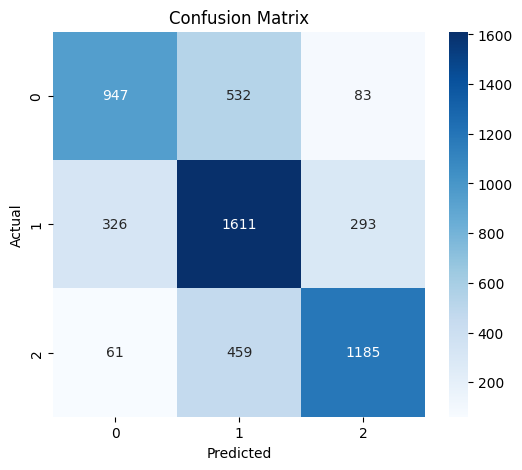

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

models = {
    'LogisticRegression3000': LogisticRegression(max_iter=3000)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"---{name}---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()